### Data Preparatie

by Kyra Jongman

### Inhoudsopgave

- Importeren packages
- Importeren data
- Functie
- Data preparatie:
    1. Conversaties converten naar kleine letters
    2. Taskmaster-2 datatset voorzien van indicatoren 
    3. Aanpassen en verwijderen van foutieve conversaties
    4. Taskmaster-2 datatset transformeren naar in- en output pair voor model

### Importeren packages

In [1]:
import pandas as pd
from price_parser import Price
import re

### Importeren data

In [2]:
url = "https://raw.githubusercontent.com/google-research-datasets/Taskmaster/master/TM-2-2020/data/hotels.json"
df = pd.read_json(url)
df.head()

,conversation_id,instruction_id,utterances
0,dlg-0010a9d6-91c2-4b9b-ad73-33b44a8b5d42,hotel-2,"[{'index': 0, 'speaker': 'ASSISTANT', 'text': ..."
1,dlg-00131332-f7b3-4227-9672-652dd3a2c39e,hotel-1b,"[{'index': 0, 'speaker': 'USER', 'text': 'I'd ..."
2,dlg-00258574-83c8-4bb0-a0f0-4f744715cb27,hotel-1c,"[{'index': 0, 'speaker': 'USER', 'text': 'I'd ..."
3,dlg-0032fc41-9845-4be6-b9f5-0e6d898fda57,hotel-8,"[{'index': 0, 'speaker': 'ASSISTANT', 'text': ..."
4,dlg-003fa5f0-3457-464b-b22b-e74194fe172a,hotel-10,"[{'index': 0, 'speaker': 'ASSISTANT', 'text': ..."


### Functie

Door deze functie aan te roepen wordt een lijst met bijvoorbeeld alle hotelnamen uit de dataset teruggegeven

In [3]:
def get_list(list_name, search_term):
    list_name = []
    for index, conversations in df['utterances'].iteritems():
        for sentences in conversations:
            if 'segments' in sentences:
                for i in sentences['segments']:
                    if search_term in i['annotations'][0]['name']:
                        list_name.append((index, sentences['index'], i['text']))
    return list_name

### Data preparatie

Stap 1: Allereerst moeten de conversaties geconverteerd worden naar kleine letters. 

In [4]:
for index, conversation in df.iterrows():
    for sentences in conversation['utterances']:
        sentences['text'] = sentences['text'].replace(sentences['text'], sentences['text'].lower())

Stap 2: Taskmaster-2 dataset voorzien van indicatoren, zie onderstaande afbeelding

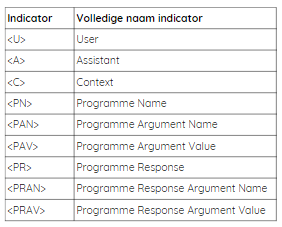

In [5]:
from PIL import Image
Image.open('Voorbeeld Indicatoren.png')

De vragen van klanten zijn aangeduid met de indicator U en de antwoorden met de indicator A. De indicatoren PN en PR geven aan welke actie er uitgevoerd moet worden; een hotel boeken of verstrekken van meer informatie. Belangrijke informatie die in de source text gegeven wordt, wordt opgeslagen in de indicatoren PAN en PAV. De indicatoren PRAN en PRAV bevatten de antwoorden op deze belangrijke informatie. Als laatste geeft de C indicator de vorige vragen en antwoorden uit het huidige gesprek weer. Het model gebruikt deze informatie als context om het volgende antwoord te formuleren.

De conversaties van de Taskmaster-2 dataset zijn voorzien van de indicatoren omdat het belangrijk is dat de digital human tijdens een conversatie met een klant kan herkennen of de klant een hotel wilt boeken of alleen meer informatie wilt. De digital human moet daarnaast ook belangrijke informatie verzamelen en hierop een antwoord formuleren. De indicatoren zorgen ervoor dat dit proces zo makkelijk als mogelijk gemaakt wordt voor de digital human. 

In [6]:
assign_tags_to_sentences = []
for index, conversations in df['utterances'].iteritems():
    hotel_information = []
    while_PRAN_inconversation = False
    for sentences in conversations:
        if 'segments' in sentences:
            annotation = sentences['segments'][0]['annotations'][0]['name']
            text = sentences['segments'][0]['text']
        if sentences['speaker'] ==  'ASSISTANT':
            if assign_tags_to_sentences:
                previous = assign_tags_to_sentences[-1][-1]
                if '<PAN>' in previous and hotel_information:
                    #selecteer laatste pan als nieuwe PRAV
                    PAN_previous = [s[4:] for s in previous.split('<') if 'PAN' in s][-1].strip()
                    assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'],'<PR>get hotel information'))
                    assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'],'<PRAN>'+PAN_previous+'<PRAV>' + sentences['text']))
            assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'], '<A>' + sentences['text']))
        else:
            assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'], '<U>' + sentences['text']))
        if 'segments' in sentences:
            if sentences['speaker'] == 'ASSISTANT':
                if 'detail.name' in annotation:
                    if '<PR>find hotel' in [sentence[3] for sentence in assign_tags_to_sentences]:
                        assign_tags_to_sentences.append((index, sentences['index']-1, sentences['speaker'], 
                                                     '<PRAN>' +  annotation
                                                     + '<PRAV>' + text))
                    else:
                        assign_tags_to_sentences.append((index, sentences['index']-1, sentences['speaker'], '<PN>find hotel'))
                        assign_tags_to_sentences.append((index, sentences['index']-1, sentences['speaker'], '<PR>find hotel'))
                        assign_tags_to_sentences.append((index, sentences['index']-1, sentences['speaker'], 
                                                         '<PRAN>' +  annotation
                                                         + '<PRAV>' + text))
                    while_PRAN_inconversation = True
            else:
                if not while_PRAN_inconversation:
                    if 'hotel_search.name' in annotation and not hotel_information:
                        hotel_information.append('<PN>get hotel information')
                        hotel_information.append('<PAN>' +  annotation
                                                     + '<PAV>' + text)
                        assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'], hotel_information[0]))
                        assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'], ' '.join(hotel_information[1:])))
                    elif hotel_information:
                        complete_info = hotel_information+['<PAN>'] +  [annotation]+ ['<PAV>'] + [text]
                        assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'], complete_info[0]))
                        assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'], ' '.join(complete_info[1:])))
                    else:
                        assign_tags_to_sentences.append((index, sentences['index'], sentences['speaker'],
                                                         '<PAN>' +  annotation
                                                         + '<PAV>' + text))

preprocess_df = pd.DataFrame(assign_tags_to_sentences, columns=['Conversation_ID', 'Text_Response_ID', 'Speaker', 'Text_Response'])
preprocess_df = preprocess_df.sort_values(['Conversation_ID', 'Text_Response_ID'], ascending=[True, True])

Voorbeeld van hoe een zin eruit ziet met indicator

In [7]:
preprocess_df.head(27)

,Conversation_ID,Text_Response_ID,Speaker,Text_Response
0,0,0,ASSISTANT,<A>hello! how can i help you?
1,0,1,USER,"<U>hi, i would like to find a hotel."
2,0,2,ASSISTANT,<A>okay.
3,0,3,ASSISTANT,<A>what else can you tell me about the hotel?
4,0,4,USER,<U>find a hotel near the beachfront.
5,0,4,USER,<PAN>hotel_search.sub_location.hotel<PAV>near ...
6,0,5,ASSISTANT,<A>okay beachfront in which town?
7,0,6,USER,<U>oxnard california.
8,0,6,USER,<PAN>hotel_search.location.hotel<PAV>Oxnard Ca...
9,0,7,ASSISTANT,<A>okay.


Stap 3: Aanpassen en verwijderen van foutieve conversaties

Enkele conversaties bevatten het woord 'goodbye' midden in een gesprek. De conversatie tussen een medewerker en klant gaat na deze zin verder waar het gebleven was. Het verwijderen van deze zinnen, heeft om deze reden geen effect op de context van het gesprek. 

In [8]:
bye_list = []
index_numbers = []
for index, conversation in df.iterrows():
    for sentences in conversation['utterances']:
        if 'bye' in sentences['text']:
            if 'ASSISTANT' in sentences['speaker']:
                assistant_bye_index = sentences['index']
            else:
                assistant_bye_index = 0
        else:
            assistant_bye_index = 0 
        bye_list.append((index, assistant_bye_index)) 
    index_numbers.append((index, sentences['index']))
   
    new_bye_list = []
    for bye in bye_list:
        if bye[1] != 0:
            new_bye_list.append(bye)
            
new_list_bye = []
for bye in new_bye_list:
    for index in index_numbers:
        if bye[0] == index[0]:
            new_list_bye.append((bye[0], bye[1], index[1]))

In [9]:
remove_byes_rows_list = []
for items in new_list_bye:
    calculation = 1-(items[1]/items[2])
    if calculation > 0.28:
        remove_byes_rows_list.append(items)

In [10]:
for remove_rows in remove_byes_rows_list:
    preprocess_df = preprocess_df.drop(preprocess_df[(preprocess_df.Conversation_ID == remove_rows[0]) & (preprocess_df.Text_Response_ID == remove_rows[1])].index)

Daarnaast bevatten enkele conversaties ook een verkeerde annotatie. Zo zegt een klant in conversatie 1728 te willen verblijven van 3 tot 11 juni. Deze zin zou eigenlijk de annotatie datum moeten krijgen, maar wordt in de data benoemd als prijsklasse. Er is besloten om deze verkeerde rijen te verwijderen, aangezien dit beter is dan het model trainen op verkeere annotaties.

In [11]:
prices = get_list('price_range', 'price_range')
for p in prices:
    if ',00' in p[2]:
        indices = preprocess_df[(preprocess_df['Conversation_ID'] == p[0]) & (preprocess_df['Text_Response_ID'] == p[1])].index
        for index in indices:
            previous_text = preprocess_df.loc[index,'Text_Response']
            preprocess_df.loc[index,'Text_Response'] = previous_text.replace(',', '')

In [12]:
price_list = []
for index, items in preprocess_df.iterrows():
        if 'price_range' in str(items['Text_Response']):
            if 'and' in items['Text_Response']:
                pass
            else:
                try:
                    p = int(re.search(r'\d+', items['Text_Response'].split(">")[2]).group())
                    price_list.append((items['Conversation_ID'], items['Text_Response_ID'], p))
                except:
                    price_list.append((items['Conversation_ID'], items['Text_Response_ID'],items[2]))

price_df = pd.DataFrame(price_list, columns=['Conversation_ID', 'Text_Response_ID', 'Price'])

In [13]:
weird_prices_list = []
for index, price in price_df.iterrows():
    try:
        money = int(price['Price'])
        if money < int(50):
            weird_prices_list.append((price['Conversation_ID'], price['Text_Response_ID'], price['Price']))
        else:
            pass
    except:
        pass

In [14]:
preprocess_df[preprocess_df['Conversation_ID'] == 1728]

,Conversation_ID,Text_Response_ID,Speaker,Text_Response
61222,1728,0,USER,<U>i'd like help finding a hotel near orleans.
61223,1728,0,USER,<PAN>hotel_search.location.hotel<PAV>Orleans
61224,1728,1,ASSISTANT,<A>can you give me some specifications?
61225,1728,2,USER,<U>i'd like someplace with free breakfast.
61226,1728,2,USER,<PAN>hotel_search.amenity<PAV>free breakfast
61227,1728,3,ASSISTANT,<A>what else do you prefer?
61228,1728,4,USER,<U>a room with a balcony.
61229,1728,4,USER,<PAN>hotel_search.amenity<PAV>balcony
61230,1728,5,ASSISTANT,<A>what are those dates?
61231,1728,6,USER,<U>i want to stay there from june 3rd to june ...


In [15]:
for remove_rows in weird_prices_list:
    preprocess_df = preprocess_df.drop(preprocess_df[(preprocess_df.Conversation_ID == remove_rows[0]) & (preprocess_df.Text_Response_ID == remove_rows[1])].index)

Als laatste was uit de Exploratory Data Analyse gebleken dat conversaties met minder dan 10 zinnen en meer dan 150 zinnen veelal bestaan uit vreemde en irrelevante conversaties. Deze conversaties zijn uit de data verwijderd

In [16]:
df_sentences = pd.DataFrame(preprocess_df.groupby(['Conversation_ID']).size(), columns=['Aantal']).reset_index()

indices = []
indices.extend([i for i in df_sentences[df_sentences['Aantal'] <= 10].index])
indices.extend([i for i in df_sentences[df_sentences['Aantal'] > 150].index])

preprocess_df.drop(indices, inplace=True)
preprocess_df = preprocess_df.reset_index(drop=True)

Stap 4: Taskmaster-2 datatset transformeren naar in- en output pair voor model

Er wordt gebruik gemaakt van de T5-base model. Dit model heeft als input waarde twee kolomemmen nodig, namelijk een soruce text (input) en een target text (gewenste output). De source text bestaat uit vragen van klanten en de target text uit de antwoorden op deze vragen.

In [17]:
adjusted_df = preprocess_df.copy()

In [18]:
#Verander speakers naar juiste speaker
adjusted_df.loc[adjusted_df['Text_Response'].str.contains('<PR>'),'Speaker'] = 'USER'
adjusted_df.loc[adjusted_df['Text_Response'].str.contains('<PRAN>'),'Speaker'] = 'USER'
adjusted_df.loc[adjusted_df['Text_Response'].str.contains('<PN>'),'Speaker'] = 'ASSISTANT'
adjusted_df.loc[adjusted_df['Text_Response'].str.contains('<PAN>'),'Speaker'] = 'ASSISTANT'
#Controleren of een conversatie begint met een assistant of een user
starters = adjusted_df.groupby('Conversation_ID').first()['Speaker']
#Voeg bij elke conversatie die begint met assistant, user toe
ASS_starters = starters.loc[starters == 'ASSISTANT'].index
for conv_id in ASS_starters:
    adjusted_df.loc[len(adjusted_df)] = [conv_id, -1, 'USER','<U> Hello']
adjusted_df = adjusted_df.sort_values(['Conversation_ID','Text_Response_ID']).reset_index(drop=True)

In [19]:
total_input = []
total_target = []
for conv_id in adjusted_df['Conversation_ID'].unique():
    current_conv = adjusted_df[adjusted_df['Conversation_ID'] == conv_id]
    current_conv.loc[:,'position'] = current_conv.loc[:,'Speaker'].ne(current_conv.loc[:,'Speaker'].shift()).cumsum()
    grouped_conv = current_conv.groupby('position')['Speaker','Conversation_ID'].first()
    grouped_conv.loc[:,'Text'] = current_conv.groupby('position')['Text_Response'].apply(lambda x: ' '.join(x))
    input_list = []
    target_list = []
    context = '<C>'
    addition = ''
    for index, row in grouped_conv.iterrows():
        if row['Speaker'] == 'USER':
            input_list.append(row['Text'] +' '+ context)
            context = context + ' ' + row['Text']
        else:
            if '<PAN>' in row['Text'] and '<PN>' not in row['Text']:
                addition += row['Text'].split('<A')[0]
            elif '<PN>find hotel' in row['Text']:
                target_list.append(row['Text'] + addition)
                context = context + ' ' + row['Text'] + addition
                continue
            target_list.append(row['Text'])
            context = context + ' ' + row['Text'] 
    if len(input_list)-len(target_list) > 0: 
        input_list = input_list[:-1]
    total_input.extend(input_list)
    total_target.extend(target_list)

C:\Users\kaj\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\kaj\AppData\Local\Temp/ipykernel_19552/1359374345.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_conv = current_conv.groupby('position')['Speaker','Conversation_ID'].first()


In [20]:
data = pd.DataFrame({'source_text': total_input, 'target_text': total_target})
data['source_text'] = 'question-answer: '  + data['source_text']

Data verdelen in train en evaluatie set

In [21]:
from sklearn.utils import shuffle
data = shuffle(data)

from sklearn.model_selection import train_test_split
train_df, eval_df = train_test_split(data, test_size=0.2)
print(train_df.shape, eval_df.shape)

(24208, 2) (6053, 2)


In [22]:
train_df.head()

,source_text,target_text
15374,question-answer: <U>hello. i would like to fin...,<A>hello. where would you like me to look?
20582,"question-answer: <U>no, that's all. <C> <U> He...","<A>thank you, goodbye."
5426,question-answer: <U>also can you make sure it ...,<PAN>hotel_search.price_range<PAV>less than $2...
16907,"question-answer: <U>sure, it works. <U>how far...",<A>one sec. <A>about a mile.
13260,question-answer: <U>okay. <PRAN>hotel1_detail....,<A>they're couple of hotels that suit your nee...


In [23]:
eval_df.head()

,source_text,target_text
14946,question-answer: <U>i'm looking a posh and tra...,<PAN>hotel_search.other_request<PAV>a posh and...
13782,question-answer: <U>close to a golf course. <C...,<PAN>hotel_search.other_request<PAV>Close to a...
4791,"question-answer: <U>can i have my survey code,...","<A>okay, hold on. <A>would you mind saying tha..."
29156,question-answer: <U>i need this hotel on march...,"<A>okay, the price just got cheaper for those ..."
26050,question-answer: <PRAN>hotel1_detail.name.hote...,<A>is the econo lodge for $46 and night. there...
